# Урок 4. Uplift-моделирование

In [59]:
# Подключаем необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest, SelectPercentile, SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV


import warnings
warnings.simplefilter('ignore')

In [72]:
# Дополнительные функции

def draw_graphic_data(index, values, title, ylabel = '', xlabel = ''):
    plt.figure(figsize =(15, 6))
    plt.plot(index, values)
    plt.title(title)
    if ylabel:
        plt.ylabel(ylabel)
    if xlabel:
        plt.xlabel(xlabel)
    plt.show()

def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result


def split_data(data, split_date):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), data.loc[data.index.get_level_values('Date') >  split_date].copy()

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


def point_prediction_model(df_w, h, split_date):
    #
    lags = 50
    sm.graphics.tsa.plot_acf(df_w['PJME_MW'].values, lags = lags)
    plt.show()
    sm.graphics.tsa.plot_pacf(df_w['PJME_MW'].values, lags = lags)
    plt.show()

    #
    diff_1 = np.array(df_w.iloc[1:,0].values - df_w.iloc[:-1,0].values).astype('float32')
    df_w['diff1'] = 0.0
    df_w['diff1'].values[1:] = diff_1

    diff_1_w = diff_1/df_w.iloc[1:,0].values
    df_w['diff1_w'] = 0.0
    df_w['diff1_w'].values[1:] = diff_1_w

    diff_1_l = np.log(df_w.iloc[1:,0].values)
    df_w['diff1_l'] = 0.0
    df_w['diff1_l'].values[1:] = diff_1_l

    diff_1_s = np.sqrt(df_w.iloc[1:,0].values)
    df_w['diff1_s'] = 0.0
    df_w['diff1_s'].values[1:] = diff_1_s

    df_w['exp_0_05'] = exponential_smoothing(df_w['PJME_MW'], 0.05)
    df_w['exp_0_5'] = exponential_smoothing(df_w['PJME_MW'], 0.5)
    df_w['exp_0_99'] = exponential_smoothing(df_w['PJME_MW'], 0.99)

    #
    N_100 = 200
    idx = df_w.index[:N_100]
    plt.plot(idx, df_w['PJME_MW'][:N_100],'r',label ='основной ряд')
    plt.plot(idx, df_w['diff1'][:N_100],'--k',label ='1-е разности')
    plt.plot(idx, df_w['exp_0_05'][:N_100],'--g',label ='экспонентциальное среднее .05')
    plt.plot(idx, df_w['exp_0_5'][:N_100],'-.b',label ='экспонентциальное среднее .5')
    plt.legend()
    plt.show()

    #
    for i in range(lags):
        df_w['t' + str(lags - i)]=0
        df_w['t' + str(lags - i)].values[lags:] = df_w['PJME_MW'].values[i : -(lags) + i]

    for i in range(lags):
        df_w['d' + str(lags - i)]=0
        df_w['d' + str(lags - i)].values[lags : ] = df_w['diff1'].values[i : -(lags) + i]

    #
    scl_target = StandardScaler()

    print(f"h = {h}\n")

    target = df_w['PJME_MW'].values[h + lags : ].reshape((df_w.shape[0] - h - lags, 1))
    y = scl_target.fit_transform(target)

    scl_x = StandardScaler()
    X = df_w.iloc[lags : -h, : ].values
    X = scl_x.fit_transform(X.astype('float64'))

    f_test, _ = f_regression(X, y.ravel())
    f_test /= np.max(f_test)

    sfk = SelectKBest(f_regression, k = 5)
    _ = sfk.fit_transform(X, y.ravel())

    sfp = SelectPercentile(f_regression, percentile = 10)
    _ = sfp.fit_transform(X, y.ravel())

    gr_model = GradientBoostingRegressor(max_depth = 5, random_state = 40, n_estimators = 100).fit(X, y.ravel())
    sfm = SelectFromModel(gr_model,  max_features = 5)

    sfm.fit(X, y.ravel())
    _ = sfm.transform(X)

    list_param_k = np.where(sfk.get_support())[0]
    list_param_p = np.where(sfp.get_support())[0]
    list_param_m = np.where(sfm.get_support())[0]

    print("Номера признаков k лучших признаков: ", list_param_k)
    print("Номера признаков лучших признаков по процентной форме: ", list_param_p)
    print("Номера признаков для выбора по модели: ", list_param_m)

    #
    list(set(list_param_k).union(list_param_p).union(list_param_m))

    list_par = list(set(list_param_k).union(list_param_p).union(list_param_m))

    X_new = X[ : , list_par]

    #
    train, test = split_data(df_w, split_date)

    plt.figure(figsize = ( 15, 6 ))
    plt.xlabel('Время')
    plt.ylabel('Потребление энергии, МВт')
    plt.plot(train.index.get_level_values('Date'), train['PJME_MW'], label='train data')
    plt.plot(test.index.get_level_values('Date'), test['PJME_MW'], label='test data')
    plt.title(f"Тестовые и тренировочные данные. h = {h}")
    plt.legend()
    plt.show()

    #
    X_train = X_new[:train.shape[0], : ]
    y_train = y[:train.shape[0] , 0]
    X_test4 = X_new[train.shape[0] : , : ]
    y_test =y[train.shape[0]:,0]

    #
    param_dist = {"max_depth": [3, 2, 1, 4, 5], "n_estimators":[100, 200, 300, 400, 500]}
    n_iter_search = 10
    model_gr = GradientBoostingRegressor()
    random_search = RandomizedSearchCV(model_gr, param_distributions = param_dist, n_iter = n_iter_search, cv = 5, iid = False)
    random_search.fit(X_train, y_train)

    #
    report(random_search.cv_results_)

    model_g_best = GradientBoostingRegressor(max_depth = 2,  n_estimators = 300)
    model_g_best.fit(X_train, y_train)
    y_test_pred_g = model_g_best.predict(X_test4)

    print(f"predict: {y_test_pred_g[3]}\ntrue: \t{y_train[3]}\n\n\n")

    return [list_par, test, X_test4, lags, y_test_pred_g, model_g_best, y_test, scl_target]


## 1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [5]:
df = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
df.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145374 entries, 2002-01-01 to 2018-08-03
Data columns (total 13 columns):
Time               145374 non-null object
PJME_MW            145374 non-null float64
year               145374 non-null int64
month              145374 non-null int64
dayofmonth         145374 non-null int64
quarter            145374 non-null int64
dayofyear          145374 non-null int64
weekofyear         145374 non-null int64
dayofweek          145374 non-null int64
hour               145374 non-null int64
is_holiday         145374 non-null int64
is_prev_holiday    145374 non-null int64
is_next_holiday    145374 non-null int64
dtypes: float64(1), int64(11), object(1)
memory usage: 19.0+ MB


In [24]:
df_week = df.resample('W').mean()
df_week.drop(columns=['year', 'hour','dayofweek','dayofmonth', 'dayofyear',
                     'is_holiday', 'is_prev_holiday', 'is_next_holiday'], axis=1,inplace=True)
df_week.head()

,PJME_MW,month,quarter,weekofyear
Date,,,,
2002-01-06,32392.160839,1.000000,1.0,1.0
2002-01-13,31487.386905,1.000000,1.0,2.0
2002-01-20,31452.880952,1.000000,1.0,3.0
2002-01-27,30141.529762,1.000000,1.0,4.0
2002-02-03,29196.488095,1.428571,1.0,5.0


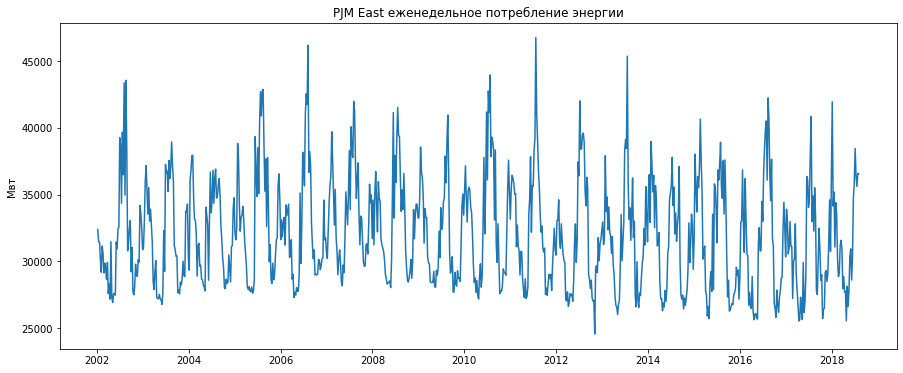

In [25]:
draw_graphic_data(df_week.index, df_week['PJME_MW'].values, 'PJM East еженедельное потребление энергии', ylabel = 'Мвт')

## 2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков.

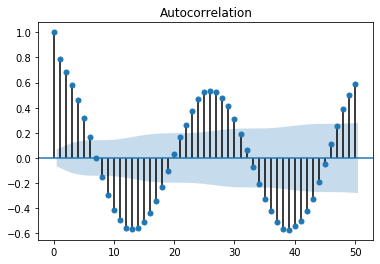

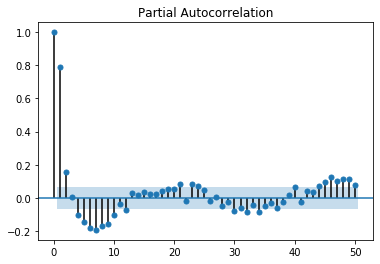

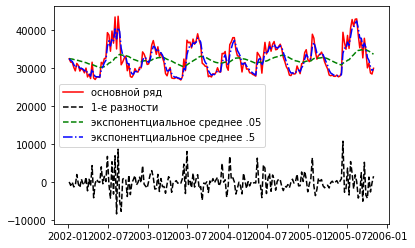

h = 4

Номера признаков k лучших признаков:  [11 12 13 14 15]
Номера признаков лучших признаков по процентной форме:  [11 12 13 14 15 25 26 27 39 52 53]
Номера признаков для выбора по модели:  [12 13 27 38 39]
Model with rank: 1
Mean validation score: 0.581 (std: 0.056)
Parameters: {'n_estimators': 100, 'max_depth': 1}

Model with rank: 2
Mean validation score: 0.573 (std: 0.069)
Parameters: {'n_estimators': 100, 'max_depth': 3}

Model with rank: 3
Mean validation score: 0.566 (std: 0.066)
Parameters: {'n_estimators': 200, 'max_depth': 2}

predict: 1.140345349811371
true: 	0.3593017521446423





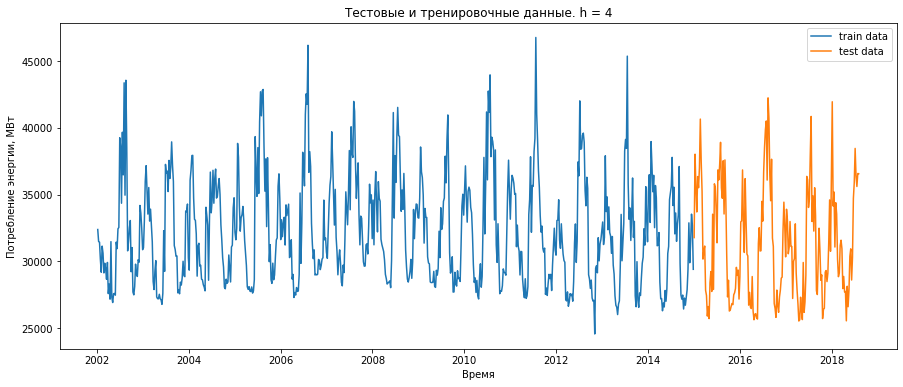

In [54]:
[list_par, test, X_test4, lags, y_test_pred_g, model_g_best, y_test, scl_target] = point_prediction_model(df_w = df_week, h = 4, split_date = '01-01-2015')

## 3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

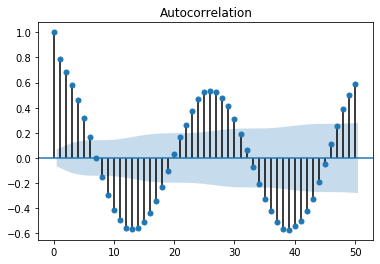

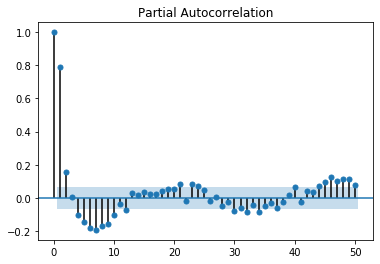

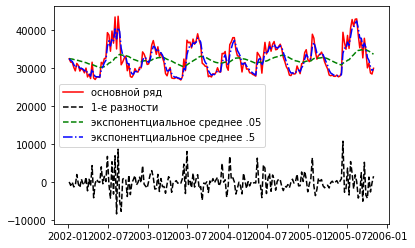

h = 1

Номера признаков k лучших признаков:  [ 0  6  7  9 10]
Номера признаков лучших признаков по процентной форме:  [ 0  6  7  9 10 11 12 23 24 59 60]
Номера признаков для выбора по модели:  [ 0  6  7  9 10]
Model with rank: 1
Mean validation score: 0.663 (std: 0.068)
Parameters: {'n_estimators': 400, 'max_depth': 1}

Model with rank: 2
Mean validation score: 0.658 (std: 0.074)
Parameters: {'n_estimators': 100, 'max_depth': 3}

Model with rank: 3
Mean validation score: 0.642 (std: 0.071)
Parameters: {'n_estimators': 200, 'max_depth': 2}

predict: 0.4427740897167554
true: 	0.9768863086968465





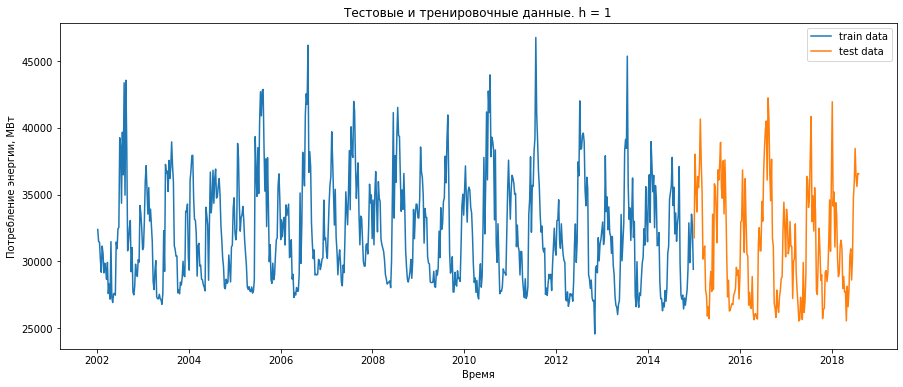

In [73]:
[list_par, test, X_test4, lags, y_test_pred_g, model_g_best, y_test, scl_target] = point_prediction_model(df_w = df_week, h = 1, split_date = '01-01-2015')

## 4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.

In [58]:
df_week.columns[list_par]

Index(['PJME_MW', 'diff1_l', 'diff1_s', 'exp_0_5', 'exp_0_99', 't50', 't49',
       't38', 't37', 't2', 't1'],
      dtype='object')

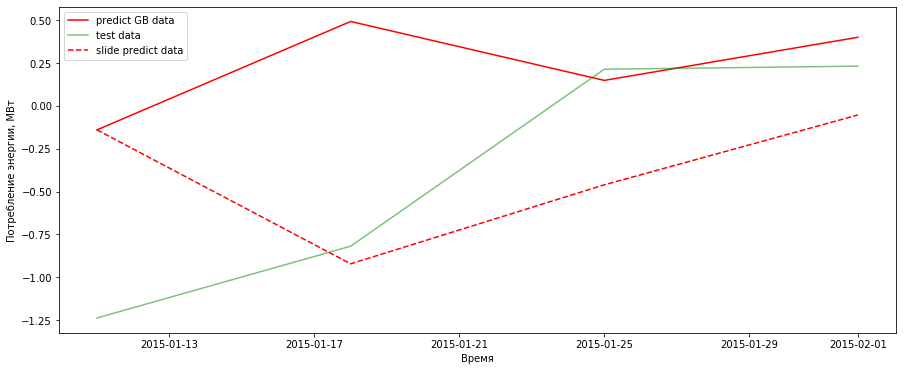

In [71]:
X_test_100 = X_test4.copy()
y_test_100 = y_test_pred_g.copy()
N_10 = 100
for i in range(N_10):
    y_test_100[i] = model_g_best.predict(np.nan_to_num(X_test_100[i, : ].reshape((1, -1))))
    # заполняем вектор для прогноза следующей точки
    X_test_100[i + 1, 0] = y_test_100[i]
    X_test_100[i + 1, 1] = np.array(X_test_100[1 : , 0] - X_test_100[ : -1, 0])[i + 1]
    X_test_100[i + 1, 2] = np.sqrt(X_test_100[1 : , 0])[i + 1]
    X_test_100[i + 1, 3] = exponential_smoothing(X_test_100[ : , 3], 0.5)[i + 1]
    X_test_100[i + 1, 4] = exponential_smoothing(X_test_100[ : , 4], 0.99)[i + 1]

    X_test_100[i + 1, 5] = y_test_100[-lags + 52]
    X_test_100[i + 1, 6] = y_test_100[-lags + 51]
    X_test_100[i + 1, 7] = y_test_100[-lags + 50]
    X_test_100[i + 1, 8] = y_test_100[-lags + 49]
    X_test_100[i + 1, 9] = y_test_100[-lags + 38]
    X_test_100[i + 1, 10] = y_test_100[-lags + 37]
    if i > lags:
        X_test_100[i + 1, 4] = np.mean(X_test_100[i + 1 - lags : i + 1, 0])


plt.figure(figsize=(15, 6))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1 : 4 + 1],y_test_pred_g[ : 4], 'r',label = 'predict GB data')
plt.plot(test.index[1 : 4 + 1],y_test[ : 4], 'g',label = 'test data', alpha = 0.5)
plt.plot(test.index[1 : 4 + 1],y_test_100[ : 4], '--r',label = 'slide predict data')
plt.legend()
plt.show()


## 5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до p-й, от p-й до 2*p-й, от 2*p-й до 3*p-й, .. .p*i-й до (i+1)*p -й,... ,от 9*p до 10*p-й точках (используйте осреденение точек, p - глубина истории, которую видим (в примере самая дальняя точка p = 6))

In [74]:
errs = []
for i in range(10):
    e = mean_absolute_percentage_error(y_true = scl_target.inverse_transform(y_test[10 * i : 10 * i + 10]),y_pred = scl_target.inverse_transform(y_test_100[10 * i : 10 * i + 10]))
    print(e)
    errs.append(e)

6.728653531902588
9.495386587388325
8.43772111174166
11.693840041977895
9.08627485136828
4.812001848636223
7.8950232612004125
16.61040508135054
10.440313054077667
7.674484092509462


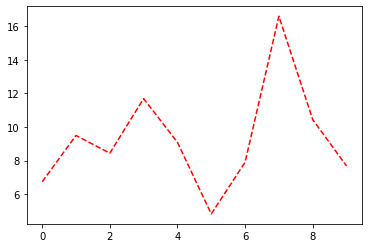

In [76]:
plt.plot(np.arange(10), errs, '--r')

## 6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

У меня подозрения, что не угадал с параметром `lags`, но если все правильно, то в модели наблюдается цикличность, помимо неё так же наблюдаются периодические скачки, но возможно это связано с сезоностью.